In [26]:
import pandas as pd
import numpy as np
import spacy
import gensim
import operator
import re
import string

In [27]:
df_schemes = pd.read_csv('../schemes2.csv', encoding='mac_roman')
df_schemes.head()

,Title,Agency,Description,Who's it for,What it gives,Link,Background Image Link,Scheme Type,search_booster(WL)
0,Caregiver Training Program,Caregivers Alliance,Provides training to caregivers of persons wit...,Caregivers,Educational programmes for caregivers,https://www.cal.org.sg/caregiver-training,https://chidnast.sirv.com/SchemesSG/CAL.jpg,"Caregiver,Mental Health",Caregivers feeling overwhelmed. Burnout. Elder...
1,Caregivers Support Centre,Caregivers Alliance,Provides support to caregivers of persons with...,Caregivers,Emotional care,https://www.cal.org.sg/caregivers-support-centre,https://chidnast.sirv.com/SchemesSG/CAL.jpg,"Caregiver,Mental Health",Caregivers feeling overwhelmed. Burnout. Elder...
2,Family LifeAid,Red Cross Singapore,Identified households receive food vouchers ev...,"Low income,Need food support","Financial assistance,Food,Educational programmes",https://www.redcross.sg/get-assistance/family-...,https://chidnast.sirv.com/SchemesSG/redcross.jpg,"Low Income,Food,Education","My client needs help to get food, meal, hungry..."
3,Food Assistance,A Packet of Rice,A self setup group which distributes meal box ...,"Low income,Need food support",Food,https://www.facebook.com/APacketOfRice/,https://chidnast.sirv.com/SchemesSG/apacketofr...,"Low Income,Food","My client needs help to get food, meal, hungry..."
4,Assistance,Filos Community Services,"Bursaries, bread distribution and food rations...","Low income,Need food support","Food,Counselling",https://www.filos.sg/services-assistance,https://chidnast.sirv.com/SchemesSG/filos.jpg,"Low Income,Food","Need to buy daily necessities, food, have not ..."


In [28]:
#Create tag list
#df_schemes['Tags'] = [x for x in df_schemes[df_schemes.columns[5:8]].values]
#df_schemes['Tags'] = df_schemes['Tags'].apply(lambda x: [i for i in x if str(i) != "nan"])
#df_schemes

#Create concatenated column
df_schemes['Combined'] = df_schemes[['Description','search_booster(WL)']].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)

In [29]:
df_schemes

,Title,Agency,Description,Who's it for,What it gives,Link,Background Image Link,Scheme Type,search_booster(WL),Combined
0,Caregiver Training Program,Caregivers Alliance,Provides training to caregivers of persons wit...,Caregivers,Educational programmes for caregivers,https://www.cal.org.sg/caregiver-training,https://chidnast.sirv.com/SchemesSG/CAL.jpg,"Caregiver,Mental Health",Caregivers feeling overwhelmed. Burnout. Elder...,Provides training to caregivers of persons wit...
1,Caregivers Support Centre,Caregivers Alliance,Provides support to caregivers of persons with...,Caregivers,Emotional care,https://www.cal.org.sg/caregivers-support-centre,https://chidnast.sirv.com/SchemesSG/CAL.jpg,"Caregiver,Mental Health",Caregivers feeling overwhelmed. Burnout. Elder...,Provides support to caregivers of persons with...
2,Family LifeAid,Red Cross Singapore,Identified households receive food vouchers ev...,"Low income,Need food support","Financial assistance,Food,Educational programmes",https://www.redcross.sg/get-assistance/family-...,https://chidnast.sirv.com/SchemesSG/redcross.jpg,"Low Income,Food,Education","My client needs help to get food, meal, hungry...",Identified households receive food vouchers ev...
3,Food Assistance,A Packet of Rice,A self setup group which distributes meal box ...,"Low income,Need food support",Food,https://www.facebook.com/APacketOfRice/,https://chidnast.sirv.com/SchemesSG/apacketofr...,"Low Income,Food","My client needs help to get food, meal, hungry...",A self setup group which distributes meal box ...
4,Assistance,Filos Community Services,"Bursaries, bread distribution and food rations...","Low income,Need food support","Food,Counselling",https://www.filos.sg/services-assistance,https://chidnast.sirv.com/SchemesSG/filos.jpg,"Low Income,Food","Need to buy daily necessities, food, have not ...","Bursaries, bread distribution and food rations..."
...,...,...,...,...,...,...,...,...,...,...
155,Children and youth services,NuLife Care & Counselling Services,"Children and youth services, particularly for ...","Children,Youth-at-risk,Youth on probation","Casework,Befriender services,Educational progr...",https://nulife.com.sg/counselling/,https://chidnast.sirv.com/SchemesSG/nulife.jpg,"Children,Youth-at-Risk,Mental Health","Child is rebellous, child hit parent, youth bu...","Children and youth services, particularly for ..."
156,Services for individials,NuLife Care & Counselling Services,"Suicide intervention, emotional support, mid-c...",In need of mental healthcare,"Casework,Befriender services,Emotional care,Co...",https://nulife.com.sg/counselling/,https://chidnast.sirv.com/SchemesSG/nulife.jpg,Mental Health,"counselling, psycho-therapy, mental health, su...","Suicide intervention, emotional support, mid-c..."
157,Legal Counselling,NuLife Care & Counselling Services,"Mediation and negotiation, deed of separation,...",In need of legal aid,Legal services,https://nulife.com.sg/counselling/,https://chidnast.sirv.com/SchemesSG/nulife.jpg,Legal Aid,"Divorce, PPO, public protection order, legal, law","Mediation and negotiation, deed of separation,..."
158,COVID-19 Assistance,NuLife Care & Counselling Services,Information on various financial assistance sc...,"Elderly,Families,Low income","Referral,Food",https://nulife.com.sg/covid-our-efforts/,https://chidnast.sirv.com/SchemesSG/nulife.jpg,"COVID-19,Food","COVID, debt, pandemic, poor, hungry, nothing t...",Information on various financial assistance sc...


In [30]:
from spacy.lang.en.stop_words import STOP_WORDS
import string

spacy_nlp = spacy.load('en_core_web_sm')

#create list of punctuations and stopwords
punctuations = string.punctuation
stop_words = spacy.lang.en.stop_words.STOP_WORDS
stop_words.pop("alone","themselves")
stop_words.add("client")

#function for data cleaning and processing
#This can be further enhanced by adding / removing reg-exps as desired.

def spacy_tokenizer(sentence):
 
    #remove distracting single quotes
    sentence = re.sub('\'','',sentence)

    #replace extra spaces with single space
    sentence = re.sub(' +',' ',sentence)

    #remove unwanted lines starting from special charcters
    sentence = re.sub(r'\n: \'\'.*','',sentence)
    sentence = re.sub(r'\n!.*','',sentence)
    sentence = re.sub(r'^:\'\'.*','',sentence)
    
    #remove non-breaking new line characters
    sentence = re.sub(r'\n',' ',sentence)
    
    #remove punctuations
    sentence = re.sub(r'[^\w\s]',' ',sentence)
    
    #creating token object
    tokens = spacy_nlp(sentence)
    
    #lower, strip and lemmatize
    tokens = [word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in tokens]
    
    #remove stopwords, and exclude words less than 2 characters
    tokens = [word for word in tokens if word not in stop_words and word not in punctuations and len(word) > 2]
    
    #return tokens
    return tokens

TypeError: pop() takes no arguments (2 given)

In [31]:
%time df_schemes['Tags_tokenized'] = df_schemes['Combined'].map(lambda x: spacy_tokenizer(x))

df_schemes

Wall time: 2.37 s


,Title,Agency,Description,Who's it for,What it gives,Link,Background Image Link,Scheme Type,search_booster(WL),Combined,Tags_tokenized
0,Caregiver Training Program,Caregivers Alliance,Provides training to caregivers of persons wit...,Caregivers,Educational programmes for caregivers,https://www.cal.org.sg/caregiver-training,https://chidnast.sirv.com/SchemesSG/CAL.jpg,"Caregiver,Mental Health",Caregivers feeling overwhelmed. Burnout. Elder...,Provides training to caregivers of persons wit...,"[provide, training, caregiver, person, mental,..."
1,Caregivers Support Centre,Caregivers Alliance,Provides support to caregivers of persons with...,Caregivers,Emotional care,https://www.cal.org.sg/caregivers-support-centre,https://chidnast.sirv.com/SchemesSG/CAL.jpg,"Caregiver,Mental Health",Caregivers feeling overwhelmed. Burnout. Elder...,Provides support to caregivers of persons with...,"[provide, support, caregiver, person, mental, ..."
2,Family LifeAid,Red Cross Singapore,Identified households receive food vouchers ev...,"Low income,Need food support","Financial assistance,Food,Educational programmes",https://www.redcross.sg/get-assistance/family-...,https://chidnast.sirv.com/SchemesSG/redcross.jpg,"Low Income,Food,Education","My client needs help to get food, meal, hungry...",Identified households receive food vouchers ev...,"[identify, household, receive, food, voucher, ..."
3,Food Assistance,A Packet of Rice,A self setup group which distributes meal box ...,"Low income,Need food support",Food,https://www.facebook.com/APacketOfRice/,https://chidnast.sirv.com/SchemesSG/apacketofr...,"Low Income,Food","My client needs help to get food, meal, hungry...",A self setup group which distributes meal box ...,"[self, setup, group, distribute, meal, box, lo..."
4,Assistance,Filos Community Services,"Bursaries, bread distribution and food rations...","Low income,Need food support","Food,Counselling",https://www.filos.sg/services-assistance,https://chidnast.sirv.com/SchemesSG/filos.jpg,"Low Income,Food","Need to buy daily necessities, food, have not ...","Bursaries, bread distribution and food rations...","[bursary, bread, distribution, food, ration, g..."
...,...,...,...,...,...,...,...,...,...,...,...
155,Children and youth services,NuLife Care & Counselling Services,"Children and youth services, particularly for ...","Children,Youth-at-risk,Youth on probation","Casework,Befriender services,Educational progr...",https://nulife.com.sg/counselling/,https://chidnast.sirv.com/SchemesSG/nulife.jpg,"Children,Youth-at-Risk,Mental Health","Child is rebellous, child hit parent, youth bu...","Children and youth services, particularly for ...","[child, youth, service, particularly, risk, yo..."
156,Services for individials,NuLife Care & Counselling Services,"Suicide intervention, emotional support, mid-c...",In need of mental healthcare,"Casework,Befriender services,Emotional care,Co...",https://nulife.com.sg/counselling/,https://chidnast.sirv.com/SchemesSG/nulife.jpg,Mental Health,"counselling, psycho-therapy, mental health, su...","Suicide intervention, emotional support, mid-c...","[suicide, intervention, emotional, support, mi..."
157,Legal Counselling,NuLife Care & Counselling Services,"Mediation and negotiation, deed of separation,...",In need of legal aid,Legal services,https://nulife.com.sg/counselling/,https://chidnast.sirv.com/SchemesSG/nulife.jpg,Legal Aid,"Divorce, PPO, public protection order, legal, law","Mediation and negotiation, deed of separation,...","[mediation, negotiation, deed, separation, app..."
158,COVID-19 Assistance,NuLife Care & Counselling Services,Information on various financial assistance sc...,"Elderly,Families,Low income","Referral,Food",https://nulife.com.sg/covid-our-efforts/,https://chidnast.sirv.com/SchemesSG/nulife.jpg,"COVID-19,Food","COVID, debt, pandemic, poor, hungry, nothing t...",Information on various financial assistance sc...,"[information, financial, assistance, scheme, h..."


In [32]:
Description_to_match = df_schemes['Tags_tokenized']
Description_to_match[0:5]

0    [provide, training, caregiver, person, mental,...
1    [provide, support, caregiver, person, mental, ...
2    [identify, household, receive, food, voucher, ...
3    [self, setup, group, distribute, meal, box, lo...
4    [bursary, bread, distribution, food, ration, g...
Name: Tags_tokenized, dtype: object

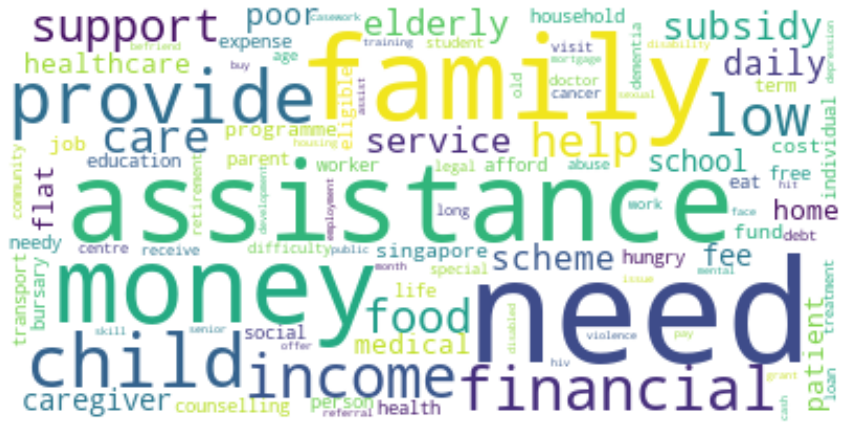

In [33]:
#Word Cloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt

series = pd.Series(np.concatenate(Description_to_match)).value_counts()[:100]
wordcloud = WordCloud(background_color='white').generate_from_frequencies(series)

plt.figure(figsize=(15,15), facecolor = None)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [34]:
#build word dictionary

from gensim import corpora

#creating term dictionary
%time dictionary = corpora.Dictionary(Description_to_match)

#filter out terms which occurs in less than 4 documents and more than 20% of the documents.
#NOTE: Since we have smaller dataset, we will keep this commented for now.

#dictionary.filter_extremes(no_below=4, no_above=0.2)

#list of few which which can be further removed
stoplist = set('hello and if this can would should could tell ask come go')
stop_ids = [dictionary.token2id[stopword] for stopword in stoplist if stopword in dictionary.token2id]
dictionary.filter_tokens(stop_ids)
dictionary.save('dictionary')

Wall time: 27.9 ms


In [35]:
#print top 50 items from the dictionary with their unique token-id
dict_tokens = [[[dictionary[key], dictionary.token2id[dictionary[key]]] for key, value in dictionary.items() if key <= 50]]
print (dict_tokens)

[[['anymore', 0], ['burnout', 1], ['caregiver', 2], ['cope', 3], ['depress', 4], ['elderly', 5], ['feel', 6], ['health', 7], ['issue', 8], ['mental', 9], ['overwhelmed', 10], ['parent', 11], ['person', 12], ['provide', 13], ['stress', 14], ['training', 15], ['support', 16], ['addition', 17], ['advance', 18], ['assessment', 19], ['benefit', 20], ['carry', 21], ['change', 22], ['child', 23], ['childcare', 24], ['chore', 25], ['client', 26], ['condition', 27], ['day', 28], ['dire', 29], ['eat', 30], ['ensure', 31], ['family', 32], ['familyí', 33], ['food', 34], ['help', 35], ['household', 36], ['households', 37], ['hungry', 38], ['identify', 39], ['improvement', 40], ['life', 41], ['meal', 42], ['meet', 43], ['money', 44], ['monitor', 45], ['month', 46], ['need', 47], ['opportunity', 48], ['periodic', 49], ['programme', 50]]]


In [36]:
#Bag of words
corpus = [dictionary.doc2bow(desc) for desc in Description_to_match]
word_frequencies = [[(dictionary[id], frequency) for id, frequency in line] for line in corpus[0:3]]
print(word_frequencies)

[[('anymore', 1), ('burnout', 1), ('caregiver', 2), ('cope', 1), ('depress', 1), ('elderly', 1), ('feel', 1), ('health', 1), ('issue', 1), ('mental', 1), ('overwhelmed', 1), ('parent', 1), ('person', 1), ('provide', 1), ('stress', 1), ('training', 1)], [('anymore', 1), ('burnout', 1), ('caregiver', 2), ('cope', 1), ('depress', 1), ('elderly', 1), ('feel', 1), ('health', 1), ('issue', 1), ('mental', 1), ('overwhelmed', 1), ('parent', 1), ('person', 1), ('provide', 1), ('stress', 1), ('support', 1)], [('elderly', 1), ('provide', 1), ('support', 1), ('addition', 1), ('advance', 1), ('assessment', 1), ('benefit', 1), ('carry', 1), ('change', 1), ('child', 3), ('childcare', 1), ('chore', 2), ('client', 1), ('condition', 1), ('day', 1), ('dire', 1), ('eat', 1), ('ensure', 1), ('family', 1), ('familyí', 1), ('food', 2), ('help', 3), ('household', 3), ('households', 1), ('hungry', 1), ('identify', 1), ('improvement', 1), ('life', 1), ('meal', 1), ('meet', 1), ('money', 1), ('monitor', 1), ('mo

In [37]:
#TF IDF and LSI
%time schemes_tfidf_model = gensim.models.TfidfModel(corpus, id2word=dictionary)
schemes_tfidf_model.save("tfidf.model")
%time schemes_lsi_model = gensim.models.LsiModel(schemes_tfidf_model[corpus], id2word=dictionary, num_topics=300)
schemes_lsi_model.save("lsi.model")

Wall time: 0 ns
Wall time: 468 ms


In [38]:
%time gensim.corpora.MmCorpus.serialize('schemes_tfidf_model_mm', schemes_tfidf_model[corpus])
%time gensim.corpora.MmCorpus.serialize('schemes_lsi_model_mm',schemes_lsi_model[schemes_tfidf_model[corpus]])

Wall time: 50.9 ms
Wall time: 99.1 ms


In [39]:
#Load indexed corpus
schemes_tfidf_corpus = gensim.corpora.MmCorpus('schemes_tfidf_model_mm')
schemes_lsi_corpus = gensim.corpora.MmCorpus('schemes_lsi_model_mm')

print(schemes_tfidf_corpus)
print(schemes_lsi_corpus)

MmCorpus(160 documents, 1312 features, 3910 non-zero entries)
MmCorpus(160 documents, 160 features, 25286 non-zero entries)


In [40]:
from gensim.similarities import MatrixSimilarity

%time schemes_index = MatrixSimilarity(schemes_lsi_corpus, num_features = schemes_lsi_corpus.num_terms)

Wall time: 80.8 ms


In [41]:
#Search similarity

from operator import itemgetter

def search_similar_schemes(search_term):
    query_bow = dictionary.doc2bow(spacy_tokenizer(search_term))
    query_tfidf = schemes_tfidf_model[query_bow]
    query_lsi = schemes_lsi_model[query_tfidf]

    schemes_index.num_best = 50

    schemes_list = schemes_index[query_lsi]

    schemes_list.sort(key=itemgetter(1), reverse=True)
    schemes_names = []

    for j, scheme in enumerate(schemes_list):

        schemes_names.append (
            {
                'Relevance': round((scheme[1] * 100),2),
                'Scheme Title': df_schemes['Title'][scheme[0]],
                'Description': df_schemes['Description'][scheme[0]]
            }

        )
        if j == (schemes_index.num_best-1):
            break

    return pd.DataFrame(schemes_names, columns=['Relevance','Scheme Title','Description'])

In [42]:
search_similar_schemes('pregnant teen')

,Relevance,Scheme Title,Description
0,82.75,Pregnancy Crisis and Support,"For emotional support, guidance, help and refe..."
1,70.01,Babes - A Helping Hand for Pregnant Teens,Staff will discuss the various options availab...
2,48.77,Information,"Information on various issues, including contr..."
3,0.00,Caregivers Training Grant (CTG),Helps caregivers defray the cost of attending ...
4,0.00,Various services,Provides rehabilitation and emotional support ...
5,0.00,Services for individials,"Suicide intervention, emotional support, mid-c..."
6,0.00,Enhanced Pilot for Private Intervention Providers,Subsidy scheme that offers more choices of ear...
7,0.00,Long / Short Term Aid,"Assistance for living expenses, medical assist..."
8,0.00,VWO Transport Subsidy Scheme,Up to 80% subsidy for transport fees supportin...
9,0.00,MUIS Special Needs Trust Scheme,Eligible families with PSNs will receive suppo...


In [43]:
import flask
print(flask.__version__)

1.1.2
